In [ ]:
# notebook for 7/10

# different regression scenarios

# 

# good controls (relationship of interest Y ~ X1)
# confound X2 -> X1, X1 -> Y, AND X2 -> Y, then Y ~ X1 + X2 is needed
# explaining away variance X1 -> Y, X2 -> Y, then Y ~ X1 + X2 is better than Y ~ X1

# bad controls 
# pipe  X2 -> X1 -> Z // Y ~ X1 is good // Y ~ X1 + X2 is bad
# selection bias X1 -> X2, X1 -> Y (tbc...)

In [ ]:
# what can go right vs what can go wrong when adding variables to a regression
# our objective is causal inference
# it's not to optimize an error function - <- machine learning

In [ ]:
# "controlling" for a factor/variable means putting it in your regression
# e.g. goal is to know the effect of X1 on Y
# e.g. Y ~ X1 + X2
# once I already know the value of X2, there is *this much* additional value in knowing X1

from utils.simdata import email_collections

df = email_collections()

In [2]:
# we work at a financial institution
# we deal in debt
# and we want people to pay
# people don't always pay
# so we're going to send an email - the email will ask people to contact us and negotiate
# we do an experiment, where we send half the people the email, and the other half don't get one
# then we measure the outcome - which is payments
df.head()

,payments,email,opened,agreement,credit_limit,risk_score
0,740,1,1.0,0.0,2348.495260,0.666752
1,580,1,1.0,1.0,334.111969,0.207395
2,600,1,1.0,1.0,1360.660722,0.550479
3,770,0,0.0,0.0,1531.828576,0.560488
4,660,0,0.0,0.0,979.855647,0.455140


In [3]:
# does receiving an email have an effect on payments?
# y ~ x
# payment ~ email

# predicted y = intercept + weight*x
# predicted payments = intercept + weight_email*email{1,0}

# for email = 1

# predicted payments = intercept + weight_email

# for email = 0

# predicted payments = intercept

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import graphviz as gr

In [4]:
result = smf.ols("payments ~ email",data = df).fit()
result.params

Intercept    669.976434
email         -0.620280
dtype: float64

<Axes: xlabel='email', ylabel='payments'>

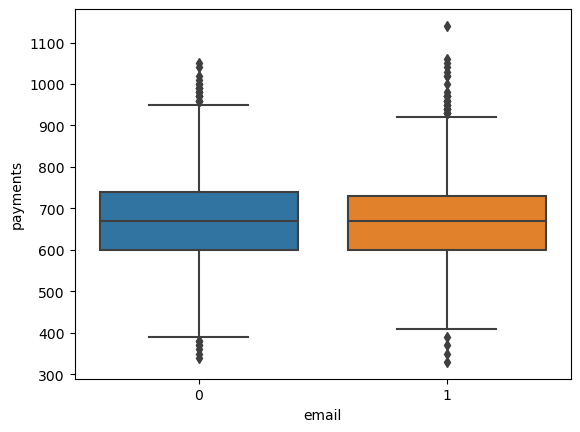

In [5]:
# predicted payments = 670 - .60*email{1,0}

# 669.4 is what we predict for those receiving the email

# 670 is what we predict for those not receiving the email

# people pay their debt for reasons that are mostly out of our control

import seaborn as sns

sns.boxplot(x = "email",y = "payments",data = df)

In [6]:
result = smf.ols("payments ~ email + risk_score + credit_limit",data = df).fit()
result.params

Intercept       490.865262
email             4.430356
risk_score       -8.051578
credit_limit      0.151069
dtype: float64

In [7]:
df.iloc[10,:]

payments         670.000000
email              0.000000
opened             0.000000
agreement          0.000000
credit_limit    1281.609741
risk_score         0.512005
Name: 10, dtype: float64

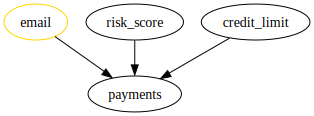

In [8]:
# predicted payments = 490 + 4.4*email - 8*riskscore + 0.15*credit_limit

# df.iloc[10,:]

# predicted payments = 490 + 4.4*0 - 8*.5 + .15*1281
# 678.15

# controlling for risk_score and credit_limit, receiving the email predicts an additional $4.4 in repayment
# sending an email doesn't cost anything
# so what would you do?

# depends on the scale - if we have millions of customers the number $4 is NOT insignificant
# google will spend millions on improving search results by a fraction of a percent
# because they get billions of searches

g = gr.Digraph()

g.node("email",color = "gold")
g.edge("email","payments")
g.edge("risk_score","payments")
g.edge("credit_limit","payments")

g

In [9]:
# hospital setting
# we're testing a medication
# we have collected data from 2 hospitals
# both of them are running an ab test (On the same drug)

# X (or T) - receiving the medication
# Y - days hospitalized

# policy for who gets the medication (policy for random assigment) is DIFFERENT between the two hospitals

# hospital 1 gives 90% of patients the treatment and 10% get placebo (no treatment)
# hospital 0 gives 10% of patients the treatment and 90% get placebo (no treatment)

# hospital usually gets the more severe cases
# why? idk, maybe they have a deal with first responders to send them severe cases

from utils.simdata import hospital_treatment

df = hospital_treatment()

In [12]:
df.head()

,hospital,treatment,severity,days
0,1,1,29.686618,82
1,1,1,20.050340,57
2,1,1,20.302399,49
3,0,0,10.603118,44
4,0,0,8.332793,15


In [13]:
# y ~ x
# __ ~ __
# y = days
# x = treatment
# days ~ treatment

result = smf.ols("days ~ treatment",data = df).fit()
result.params

Intercept    33.266667
treatment    14.153333
dtype: float64

In [17]:
# predicted number of days = 33 + 14*treatment

# treatment in [0,1]

# if treatment

# 47

# if no treatment

# 33

# why not just split the data by hospital

hosp_1 = smf.ols("days ~ treatment",data = df[df['hospital'] == 1]).fit()
hosp_0 = smf.ols("days ~ treatment",data = df[df['hospital'] == 0]).fit()

In [18]:
hosp_1.params

Intercept    59.000000
treatment   -10.395833
dtype: float64

In [19]:
hosp_0.params

Intercept    30.407407
treatment   -11.407407
dtype: float64

In [20]:
hosp_1.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,59.0000,6.747,8.745,0.000,45.442,72.558
treatment,-10.3958,6.955,-1.495,0.141,-24.371,3.580


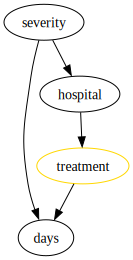

In [21]:

g = gr.Digraph()

g.node("treatment",color = "gold")
g.edge("treatment","days")
g.edge("severity","days")
g.edge("severity","hospital")
g.edge("hospital","treatment")

g

In [26]:
result = smf.ols("days ~ treatment + severity",data = df).fit()
result.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,11.6641,2.000,5.832,0.000,7.681,15.647
treatment,-7.5912,2.269,-3.345,0.001,-12.110,-3.073
severity,2.2741,0.154,14.793,0.000,1.968,2.580


In [23]:
# predicted days = 12 - 7*treatment + 2*severity
df.sample(2)

# index 75
# predicted: 12 - 7*1 + 2*19 = 43 
# actual: 41

# index 62
# predicted: 12 -7*0 + 2*9 = 30
# actual: 31


,hospital,treatment,severity,days
75,1,1,18.879462,41
62,0,0,9.393171,31


In [27]:
result = smf.ols("days ~ treatment + severity + hospital",data = df).fit()
result.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,11.0111,2.118,5.198,0.000,6.792,15.230
treatment,-5.0945,3.492,-1.459,0.149,-12.049,1.861
severity,2.3865,0.195,12.251,0.000,1.999,2.774
hospital,-4.1535,4.413,-0.941,0.350,-12.943,4.636


In [ ]:
# rule 1: if you have a variable that is a good predictor of the treatment and the outcome, then you should include it in your regression 
# rule 1 example: severity. severity is a good predictor of the getting the treatment (through hospital) and also a good predictor of days
# rule 2: if you have a variable that is a good predictor of the outcome, but unrelated to the treatment, you should include it.
# rule example: risk_score/credit_limit are good predictors of payments but they are independent of email (because email was random)

# rule 1 and 2 are examples of things you SHOULD do

# rule 3: if you have a variable that is ONLY a good predictor for the treatment then don't include it
# rule 3 example: including hospital once you already know severity

In [28]:
result = smf.ols("days ~ treatment + hospital",data = df).fit()
result.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,30.3654,2.419,12.555,0.000,25.549,35.182
treatment,-10.7978,5.930,-1.821,0.073,-22.607,1.011
hospital,29.0130,5.972,4.858,0.000,17.120,40.906
